In [59]:
# Copyright 2019 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
from scipy.stats import gaussian_kde as GKDE
from luq import *

The model is the Liénard system, a second order ODE system, which models oscillating circuits:
    $$ u' = v $$
    $$ v' = -u + (\mu - u^2) v. $$
    
The initial conditions are given by $u(0) = u_0 \in \mathbb{R}$ and 
$v(0) = v_0 \in \mathbb{R}$.

The system has a supercritical Hopf bifurcation at $\mu = 0$. There is a 
stable periodic orbit for $\mu > 0$ and the origin is a stable focus for $\mu < 0$. 
See https://www.math.colostate.edu/~shipman/47/volume3b2011/M640_MunozAlicea.pdf 
    for more details.
    
The system is solved numerically using the RK45 method.

A ***true*** distribution of $\mu, u_0$, and $v_0$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.
    
    

In [60]:

# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(1e3)

params = np.random.uniform(size=(num_samples, 1))
param_range = np.array([[-0.5, 0.5]]) # range for nu

ics = np.random.uniform(size=(num_samples, 2))
ic_range = np.array([[0.1, 0.5], [-0.5, -0.1]]) # range for u_0 and v_0  

params = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params
ics = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics

# labels
param_labels = [r'$\mu$']
ic_labels = [r'$u_0$', r'$v_0$']


# Construct the predicted time series data
num_time_preds = int(500)  # number of predictions (uniformly spaced) between [time_start,time_end]
time_start = 0.5
time_end = 40.0
times = np.linspace(time_start, time_end, num_time_preds)

# Solve systems
phys = ds.Lienard()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)

In [61]:
# Simulate an observed Beta distribution of time series data
num_obs = int(1e3)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 1), a=true_a, b=true_b)
ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b) 

params_obs = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params_obs
ics_obs = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics_obs

# Solve systems
observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)

# Add noise if desired
with_noise = False
noise_stdev = 0.05

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs)

In [62]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 350
time_end_idx = 499

# Clean data with piecewise constant linear splines
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=50, tol=3.0e-2, min_knots=15, max_knots=40)


0 16 0.0154485642906895
0 16 knots being used with error of 0.0154485642906895
1 16 0.013748759468540622
1 16 knots being used with error of 0.013748759468540622
2 16 0.016278895298937467
2 16 knots being used with error of 0.016278895298937467
3 16 0.014872502495964349
3 16 knots being used with error of 0.014872502495964349
4 16 0.017015571706231802
4 16 knots being used with error of 0.017015571706231802
5 16 0.01510690001902621
5 16 knots being used with error of 0.01510690001902621
6 16 0.015427552430621848
6 16 knots being used with error of 0.015427552430621848
7 16 0.013577392235113513
7 16 knots being used with error of 0.013577392235113513
8 16 0.013314698102698223
8 16 knots being used with error of 0.013314698102698223
9 16 0.016441253378417776
9 16 knots being used with error of 0.016441253378417776
10 16 0.014603915108857769
10 16 knots being used with error of 0.014603915108857769
11 16 0.014733233685299543
11 16 knots being used with error of 0.014733233685299543
12 16 

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


13 16 0.01587083501893103
13 16 knots being used with error of 0.01587083501893103
14 16 0.014522341367662655
14 16 knots being used with error of 0.014522341367662655
15 16 0.01622922347477875
15 16 knots being used with error of 0.01622922347477875
16 16 0.013684447362970488
16 16 knots being used with error of 0.013684447362970488
17 16 0.013084656404669513
17 16 knots being used with error of 0.013084656404669513
18 16 0.015648034328479398
18 16 knots being used with error of 0.015648034328479398
19 16 0.014988084620334895
19 16 knots being used with error of 0.014988084620334895
20 16 0.01613202779222845
20 16 knots being used with error of 0.01613202779222845
21 16 0.014399446926013844
21 16 knots being used with error of 0.014399446926013844
22 16 0.014885076549625991
22 16 knots being used with error of 0.014885076549625991
23 16 0.018006768349087158
23 16 knots being used with error of 0.018006768349087158
24 16 0.012375064271962563
24 16 knots being used with error of 0.01237

111 16 0.012823007977346809
111 16 knots being used with error of 0.012823007977346809
112 16 0.01712300017484971
112 16 knots being used with error of 0.01712300017484971
113 16 0.014613469591265226
113 16 knots being used with error of 0.014613469591265226
114 16 0.015736558097140137
114 16 knots being used with error of 0.015736558097140137
115 16 0.014339733955789932
115 16 knots being used with error of 0.014339733955789932
116 16 0.015250705312842897
116 16 knots being used with error of 0.015250705312842897
117 16 0.014807067942332877
117 16 knots being used with error of 0.014807067942332877
118 16 0.014152192377052565
118 16 knots being used with error of 0.014152192377052565
119 16 0.015776048601822565
119 16 knots being used with error of 0.015776048601822565
120 16 0.013890923060815859
120 16 knots being used with error of 0.013890923060815859
121 16 0.018080262269409047
121 16 knots being used with error of 0.018080262269409047
122 16 0.013986270873897326
122 16 knots bein

207 16 0.014357713025840806
207 16 knots being used with error of 0.014357713025840806
208 16 0.014194302396492773
208 16 knots being used with error of 0.014194302396492773
209 16 0.013073288164215461
209 16 knots being used with error of 0.013073288164215461
210 16 0.014820428012987085
210 16 knots being used with error of 0.014820428012987085
211 16 0.014879973201861884
211 16 knots being used with error of 0.014879973201861884
212 16 0.014406182953037378
212 16 knots being used with error of 0.014406182953037378
213 16 0.01670523018743439
213 16 knots being used with error of 0.01670523018743439
214 16 0.01426263329551825
214 16 knots being used with error of 0.01426263329551825
215 16 0.014910628992450716
215 16 knots being used with error of 0.014910628992450716
216 16 0.014074921638865224
216 16 knots being used with error of 0.014074921638865224
217 16 0.01411215607810385
217 16 knots being used with error of 0.01411215607810385
218 16 0.014741374399506716
218 16 knots being us

303 16 0.018130912249943832
303 16 knots being used with error of 0.018130912249943832
304 16 0.014262828807034007
304 16 knots being used with error of 0.014262828807034007
305 16 0.01873338767828172
305 16 knots being used with error of 0.01873338767828172
306 16 0.015928337371865935
306 16 knots being used with error of 0.015928337371865935
307 16 0.015270041176948256
307 16 knots being used with error of 0.015270041176948256
308 16 0.015661715417206623
308 16 knots being used with error of 0.015661715417206623
309 16 0.013796749802736326
309 16 knots being used with error of 0.013796749802736326
310 16 0.015407181332750534
310 16 knots being used with error of 0.015407181332750534
311 16 0.014607536054169342
311 16 knots being used with error of 0.014607536054169342
312 16 0.012546911430221718
312 16 knots being used with error of 0.012546911430221718
313 16 0.013696809807924083
313 16 knots being used with error of 0.013696809807924083
314 16 0.013837483845800089
314 16 knots bein

398 16 0.01355551830486379
398 16 knots being used with error of 0.01355551830486379
399 16 0.014334664107592644
399 16 knots being used with error of 0.014334664107592644
400 16 0.013783193091892179
400 16 knots being used with error of 0.013783193091892179
401 16 0.014803906202209949
401 16 knots being used with error of 0.014803906202209949
402 16 0.025079828366424306
402 16 knots being used with error of 0.025079828366424306
403 16 0.014985670459776255
403 16 knots being used with error of 0.014985670459776255
404 16 0.013492947240756704
404 16 knots being used with error of 0.013492947240756704
405 16 0.01441106009416082
405 16 knots being used with error of 0.01441106009416082
406 16 0.015715492181918752
406 16 knots being used with error of 0.015715492181918752
407 16 0.015870061677834457
407 16 knots being used with error of 0.015870061677834457
408 16 0.014611153846387635
408 16 knots being used with error of 0.014611153846387635
409 16 0.01351012110130525
409 16 knots being u

495 16 0.014007186065808919
495 16 knots being used with error of 0.014007186065808919
496 16 0.014833977201031112
496 16 knots being used with error of 0.014833977201031112
497 16 0.01405111419998664
497 16 knots being used with error of 0.01405111419998664
498 16 0.014902329274476113
498 16 knots being used with error of 0.014902329274476113
499 16 0.013693804799410946
499 16 knots being used with error of 0.013693804799410946
500 16 0.016252963306141927
500 16 knots being used with error of 0.016252963306141927
501 16 0.014177511819783911
501 16 knots being used with error of 0.014177511819783911
502 16 0.01441114342881489
502 16 knots being used with error of 0.01441114342881489
503 16 0.016353737275569397
503 16 knots being used with error of 0.016353737275569397
504 16 0.016805256835993796
504 16 knots being used with error of 0.016805256835993796
505 16 0.014959261914055217
505 16 knots being used with error of 0.014959261914055217
506 16 0.015441757900138261
506 16 knots being 

590 16 0.014209791558158285
590 16 knots being used with error of 0.014209791558158285
591 16 0.01555991219168351
591 16 knots being used with error of 0.01555991219168351
592 16 0.013651437664810535
592 16 knots being used with error of 0.013651437664810535
593 16 0.013964931233952154
593 16 knots being used with error of 0.013964931233952154
594 16 0.013739771607605034
594 16 knots being used with error of 0.013739771607605034
595 16 0.013402578065250033
595 16 knots being used with error of 0.013402578065250033
596 16 0.014749342732294802
596 16 knots being used with error of 0.014749342732294802
597 16 0.013742600535554154
597 16 knots being used with error of 0.013742600535554154
598 16 0.014592419349401501
598 16 knots being used with error of 0.014592419349401501
599 16 0.016072106645343295
599 16 knots being used with error of 0.016072106645343295
600 16 0.01467434597966777
600 16 knots being used with error of 0.01467434597966777
601 16 0.017377026184981516
601 16 knots being 

687 16 0.014123755446426075
687 16 knots being used with error of 0.014123755446426075
688 16 0.014917443220946144
688 16 knots being used with error of 0.014917443220946144
689 16 0.013697588071022079
689 16 knots being used with error of 0.013697588071022079
690 16 0.014666219531974065
690 16 knots being used with error of 0.014666219531974065
691 16 0.012638031004563715
691 16 knots being used with error of 0.012638031004563715
692 16 0.013275999648198871
692 16 knots being used with error of 0.013275999648198871
693 16 0.014993995067378186
693 16 knots being used with error of 0.014993995067378186
694 16 0.014219954482221348
694 16 knots being used with error of 0.014219954482221348
695 16 0.014982277729849038
695 17 0.014114124945750203
695 17 knots being used with error of 0.014114124945750203
696 16 0.013831003644511303
696 16 knots being used with error of 0.013831003644511303
697 16 0.013817499416174266
697 16 knots being used with error of 0.013817499416174266
698 16 0.014436

782 16 0.014637475664827041
782 16 knots being used with error of 0.014637475664827041
783 16 0.014920781314070047
783 16 knots being used with error of 0.014920781314070047
784 16 0.013577697333745744
784 16 knots being used with error of 0.013577697333745744
785 16 0.013713015149435166
785 16 knots being used with error of 0.013713015149435166
786 16 0.015525648617656502
786 16 knots being used with error of 0.015525648617656502
787 16 0.014500343311102741
787 16 knots being used with error of 0.014500343311102741
788 16 0.015346235668053392
788 16 knots being used with error of 0.015346235668053392
789 16 0.018847302402632302
789 16 knots being used with error of 0.018847302402632302
790 16 0.015236538593437056
790 16 knots being used with error of 0.015236538593437056
791 16 0.015695099127822968
791 16 knots being used with error of 0.015695099127822968
792 16 0.015076766933695588
792 16 knots being used with error of 0.015076766933695588
793 16 0.01348871871434506
793 16 knots bei

878 16 0.014886465341369991
878 16 knots being used with error of 0.014886465341369991
879 16 0.014162059177530694
879 16 knots being used with error of 0.014162059177530694
880 16 0.016472850825714862
880 16 knots being used with error of 0.016472850825714862
881 16 0.016459671475268476
881 16 knots being used with error of 0.016459671475268476
882 16 0.015312611748888968
882 16 knots being used with error of 0.015312611748888968
883 16 0.01551009484464372
883 16 knots being used with error of 0.01551009484464372
884 16 0.014078350345397131
884 16 knots being used with error of 0.014078350345397131
885 16 0.013896327615828156
885 16 knots being used with error of 0.013896327615828156
886 16 0.013229089082202843
886 16 knots being used with error of 0.013229089082202843
887 16 0.014660509565653046
887 16 knots being used with error of 0.014660509565653046
888 16 0.014064728242983044
888 16 knots being used with error of 0.014064728242983044
889 16 0.01451546070035113
889 16 knots being

974 16 0.015131632582538601
974 16 knots being used with error of 0.015131632582538601
975 16 0.01267012609456976
975 16 knots being used with error of 0.01267012609456976
976 16 0.017583126176226423
976 16 knots being used with error of 0.017583126176226423
977 16 0.017164827934372018
977 16 knots being used with error of 0.017164827934372018
978 16 0.017017050331335052
978 16 knots being used with error of 0.017017050331335052
979 16 0.013962070366105469
979 16 knots being used with error of 0.013962070366105469
980 16 0.013476737175813483
980 16 knots being used with error of 0.013476737175813483
981 16 0.013978920936266672
981 16 knots being used with error of 0.013978920936266672
982 16 0.013830652194351178
982 16 knots being used with error of 0.013830652194351178
983 16 0.02358794695947095
983 16 knots being used with error of 0.02358794695947095
984 16 0.013009640799593693
984 16 knots being used with error of 0.013009640799593693
985 16 0.014397848780823858
985 16 knots being 

71 16 0.01478056287988862
71 16 knots being used with error of 0.01478056287988862
72 16 0.014059288143789365
72 16 knots being used with error of 0.014059288143789365
73 16 0.014731212485347912
73 16 knots being used with error of 0.014731212485347912
74 16 0.014279184641219245
74 16 knots being used with error of 0.014279184641219245
75 16 0.016059539534288098
75 16 knots being used with error of 0.016059539534288098
76 16 0.01504288385153657
76 16 knots being used with error of 0.01504288385153657
77 16 0.013025019897079677
77 16 knots being used with error of 0.013025019897079677
78 16 0.013782045060389448
78 16 knots being used with error of 0.013782045060389448
79 16 0.015539560462490979
79 16 knots being used with error of 0.015539560462490979
80 16 0.01444225581339836
80 16 knots being used with error of 0.01444225581339836
81 16 0.015675749663573085
81 16 knots being used with error of 0.015675749663573085
82 16 0.014113462599297882
82 16 knots being used with error of 0.01411

168 16 0.012936485526132286
168 16 knots being used with error of 0.012936485526132286
169 16 0.014821599853177164
169 16 knots being used with error of 0.014821599853177164
170 16 0.015358160139060013
170 16 knots being used with error of 0.015358160139060013
171 16 0.015087737942338558
171 16 knots being used with error of 0.015087737942338558
172 16 0.013730319747499841
172 16 knots being used with error of 0.013730319747499841
173 16 0.013988917057311543
173 16 knots being used with error of 0.013988917057311543
174 16 0.015220314638382526
174 16 knots being used with error of 0.015220314638382526
175 16 0.015747066232152336
175 16 knots being used with error of 0.015747066232152336
176 16 0.014717402587249217
176 16 knots being used with error of 0.014717402587249217
177 16 0.014801104685189607
177 16 knots being used with error of 0.014801104685189607
178 16 0.017787692931294192
178 16 knots being used with error of 0.017787692931294192
179 16 0.015054118769420375
179 16 knots be

263 16 0.014487560422915663
263 16 knots being used with error of 0.014487560422915663
264 16 0.014742568257144411
264 16 knots being used with error of 0.014742568257144411
265 16 0.01565711550269019
265 16 knots being used with error of 0.01565711550269019
266 16 0.014873640830896151
266 16 knots being used with error of 0.014873640830896151
267 16 0.014212511831394091
267 16 knots being used with error of 0.014212511831394091
268 16 0.013084769422507966
268 16 knots being used with error of 0.013084769422507966
269 16 0.016544519419609438
269 16 knots being used with error of 0.016544519419609438
270 16 0.014973937837426586
270 16 knots being used with error of 0.014973937837426586
271 16 0.014153521642300413
271 16 knots being used with error of 0.014153521642300413
272 16 0.014188353573334709
272 16 knots being used with error of 0.014188353573334709
273 16 0.014867769470956478
273 16 knots being used with error of 0.014867769470956478
274 16 0.014057732562836473
274 16 knots bein

360 16 0.015170157199822398
360 16 knots being used with error of 0.015170157199822398
361 16 0.017452897547205467
361 16 knots being used with error of 0.017452897547205467
362 16 0.014928472229151135
362 16 knots being used with error of 0.014928472229151135
363 16 0.013917270435584696
363 16 knots being used with error of 0.013917270435584696
364 16 0.019644944817615757
364 16 knots being used with error of 0.019644944817615757
365 16 0.013525397940601687
365 16 knots being used with error of 0.013525397940601687
366 16 0.01441394442129406
366 16 knots being used with error of 0.01441394442129406
367 16 0.016756266154051815
367 16 knots being used with error of 0.016756266154051815
368 16 0.012644516581454854
368 16 knots being used with error of 0.012644516581454854
369 16 0.016627436262962394
369 16 knots being used with error of 0.016627436262962394
370 16 0.02209196571783852
370 16 knots being used with error of 0.02209196571783852
371 16 0.013848984889869647
371 16 knots being 

457 16 0.015321544580516181
457 16 knots being used with error of 0.015321544580516181
458 16 0.01477246385243945
458 16 knots being used with error of 0.01477246385243945
459 16 0.014466772031390858
459 16 knots being used with error of 0.014466772031390858
460 16 0.017038773917245526
460 16 knots being used with error of 0.017038773917245526
461 16 0.013970040580382858
461 16 knots being used with error of 0.013970040580382858
462 16 0.0136298216103344
462 16 knots being used with error of 0.0136298216103344
463 16 0.013973221620235555
463 16 knots being used with error of 0.013973221620235555
464 16 0.017300609946751973
464 16 knots being used with error of 0.017300609946751973
465 16 0.015335280480325467
465 16 knots being used with error of 0.015335280480325467
466 16 0.013782205604515518
466 16 knots being used with error of 0.013782205604515518
467 16 0.014396726404209909
467 16 knots being used with error of 0.014396726404209909
468 16 0.014581180639346755
468 16 knots being us

553 16 0.015516581245391644
553 16 knots being used with error of 0.015516581245391644
554 16 0.01485380457984345
554 16 knots being used with error of 0.01485380457984345
555 16 0.01363365676523759
555 16 knots being used with error of 0.01363365676523759
556 16 0.01375371771034421
556 16 knots being used with error of 0.01375371771034421
557 16 0.013716584322676398
557 16 knots being used with error of 0.013716584322676398
558 16 0.015695487987768646
558 16 knots being used with error of 0.015695487987768646
559 16 0.015016724317912882
559 16 knots being used with error of 0.015016724317912882
560 16 0.015616502898192419
560 16 knots being used with error of 0.015616502898192419
561 16 0.022628972189234126
561 16 knots being used with error of 0.022628972189234126
562 16 0.013382173072727939
562 16 knots being used with error of 0.013382173072727939
563 16 0.016872676320378536
563 16 knots being used with error of 0.016872676320378536
564 16 0.014589455734798721
564 16 knots being us

649 16 0.013784669011016614
649 16 knots being used with error of 0.013784669011016614
650 16 0.013498146868722282
650 16 knots being used with error of 0.013498146868722282
651 16 0.013522188076947963
651 16 knots being used with error of 0.013522188076947963
652 16 0.016362827565699414
652 16 knots being used with error of 0.016362827565699414
653 16 0.013777108603144185
653 16 knots being used with error of 0.013777108603144185
654 16 0.015337014392031762
654 16 knots being used with error of 0.015337014392031762
655 16 0.01410044570587555
655 16 knots being used with error of 0.01410044570587555
656 16 0.019164054978199067
656 16 knots being used with error of 0.019164054978199067
657 16 0.01434228327915991
657 16 knots being used with error of 0.01434228327915991
658 16 0.014879097186442652
658 16 knots being used with error of 0.014879097186442652
659 16 0.017289742635746168
659 16 knots being used with error of 0.017289742635746168
660 16 0.013257382326030137
660 16 knots being 

745 16 0.014874092003997978
745 16 knots being used with error of 0.014874092003997978
746 16 0.014284377846010705
746 16 knots being used with error of 0.014284377846010705
747 16 0.01668721566093923
747 16 knots being used with error of 0.01668721566093923
748 16 0.02225667269715082
748 16 knots being used with error of 0.02225667269715082
749 16 0.017242995815023105
749 16 knots being used with error of 0.017242995815023105
750 16 0.015069280236726707
750 16 knots being used with error of 0.015069280236726707
751 16 0.01728537845076164
751 16 knots being used with error of 0.01728537845076164
752 16 0.014901646831028324
752 16 knots being used with error of 0.014901646831028324
753 16 0.015184669001619727
753 16 knots being used with error of 0.015184669001619727
754 16 0.01402269150496746
754 16 knots being used with error of 0.01402269150496746
755 16 0.014540606019259491
755 16 knots being used with error of 0.014540606019259491
756 16 0.015018631637536499
756 16 knots being used

841 16 0.014863314071313128
841 16 knots being used with error of 0.014863314071313128
842 16 0.01575694519070113
842 16 knots being used with error of 0.01575694519070113
843 16 0.014636084415042458
843 16 knots being used with error of 0.014636084415042458
844 16 0.01451649766669937
844 16 knots being used with error of 0.01451649766669937
845 16 0.015985522980430777
845 16 knots being used with error of 0.015985522980430777
846 16 0.01518951823301454
846 16 knots being used with error of 0.01518951823301454
847 16 0.014192709963255007
847 16 knots being used with error of 0.014192709963255007
848 16 0.022508770713734798
848 16 knots being used with error of 0.022508770713734798
849 16 0.017865554920502746
849 16 knots being used with error of 0.017865554920502746
850 16 0.014276871343920078
850 16 knots being used with error of 0.014276871343920078
851 16 0.015336490611614009
851 16 knots being used with error of 0.015336490611614009
852 16 0.01572512025818025
852 16 knots being use

938 16 0.013691648823571002
938 16 knots being used with error of 0.013691648823571002
939 16 0.0147642747299405
939 16 knots being used with error of 0.0147642747299405
940 16 0.013626146976443721
940 16 knots being used with error of 0.013626146976443721
941 16 0.01466822208639459
941 16 knots being used with error of 0.01466822208639459
942 16 0.013425397881903198
942 16 knots being used with error of 0.013425397881903198
943 16 0.02278231090505244
943 16 knots being used with error of 0.02278231090505244
944 16 0.013429812650098686
944 16 knots being used with error of 0.013429812650098686
945 16 0.014477822033325916
945 16 knots being used with error of 0.014477822033325916
946 16 0.01563379479574198
946 16 knots being used with error of 0.01563379479574198
947 16 0.013597832042246656
947 16 knots being used with error of 0.013597832042246656
948 16 0.014185765745801814
948 16 knots being used with error of 0.014185765745801814
949 16 0.014675547347295202
949 16 knots being used w

(array([[-1.00470733e+00, -8.08039621e-01, -6.11371907e-01, ...,
         -8.65257298e-01, -1.05371818e+00, -1.20280627e+00],
        [-9.13855495e-04, -7.25017383e-04, -5.36179270e-04, ...,
         -4.84077533e-05, -6.33907067e-05, -7.83736601e-05],
        [-8.77694659e-01, -6.40560690e-01, -4.03426721e-01, ...,
         -1.23286443e+00, -1.31340573e+00, -1.39394702e+00],
        ...,
        [-1.02925854e+00, -7.96222632e-01, -5.63186721e-01, ...,
         -1.19500592e+00, -1.31392797e+00, -1.43285001e+00],
        [-3.65638718e-02, -3.15054725e-02, -2.64470732e-02, ...,
         -7.46322339e-03, -9.59223606e-03, -1.17212487e-02],
        [-6.72234784e-02, -4.67567596e-02, -2.62900407e-02, ...,
         -4.56523415e-02, -4.83635857e-02, -5.10748298e-02]]),
 array([[-2.11334635e-01, -1.82185863e-01, -1.53037091e-01, ...,
         -1.04269679e-01, -1.30733979e-01, -1.57198279e-01],
        [-1.07652842e-02, -9.30455917e-03, -7.69654748e-03, ...,
         -1.17015115e-03, -1.55724376e

In [63]:
# Learn and classify dynamics.
learn.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 2, 'n_init': 10})

0.002 misclassification rate for  {'kernel': 'linear'}
0.01 misclassification rate for  {'kernel': 'rbf'}
0.026000000000000002 misclassification rate for  {'kernel': 'poly'}
0.011 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.002


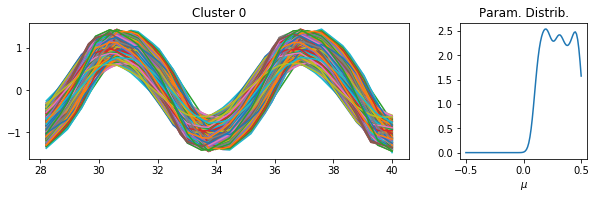

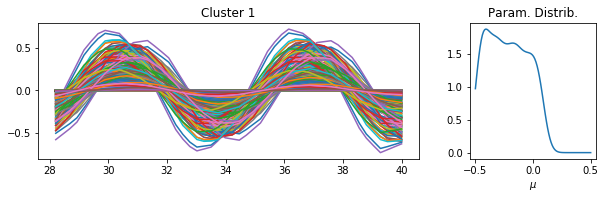

In [64]:
# Plot clusters of predicted time series
for j in range(learn.num_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
    ps = []
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            ps.append(params[i,0])
            ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
    ax1.set(title='Cluster ' + str(j))
    xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
    ax2.plot(xs, GKDE(ps)(xs))
    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')


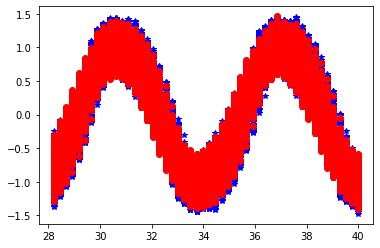

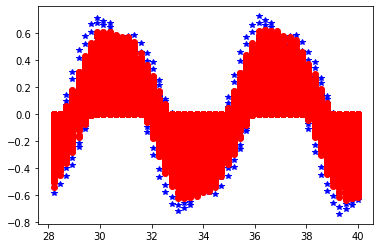

In [65]:
# Plot observed and predicted clusters
for j in range(learn.num_clusters):
    plt.figure()
    cluster_num = j
    for i in range(num_samples):
        if learn.predict_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
    for i in range(num_obs):
        if learn.obs_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [66]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=3)

3 principal components explain 99.6989% of variance for cluster 0 with {'kernel': 'linear'}
3 principal components explain 62.7999% of variance for cluster 0 with {'kernel': 'rbf'}
3 principal components explain 94.6895% of variance for cluster 0 with {'kernel': 'sigmoid'}
3 principal components explain 78.7063% of variance for cluster 0 with {'kernel': 'poly'}
3 principal components explain 99.5950% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'linear'}
3 principal components explain 99.6989% of variance.
3 principal components explain 99.9439% of variance for cluster 1 with {'kernel': 'linear'}
3 principal components explain 69.2248% of variance for cluster 1 with {'kernel': 'rbf'}
3 principal components explain 94.4424% of variance for cluster 1 with {'kernel': 'sigmoid'}
3 principal components explain 96.7759% of variance for cluster 1 with {'kernel': 'poly'}
3 principal components explain 99.8530% of variance for cluster 1 with {'ker

In [67]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals=learn.compute_r()

Average rejection rates for clusters: [1.559611308762833, 0.8204558068995904]


In [68]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
ic_marginals = []
true_param_marginals = []
true_ic_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        
for i in range(ics.shape[1]):
    true_ic_marginals.append(GKDE(ics_obs[:,i]))
    ic_marginals.append([])
    for j in range(learn.num_clusters):
        ic_marginals[i].append(GKDE(ics[lam_ptr[j], i], weights=learn.r[j]))

In [69]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

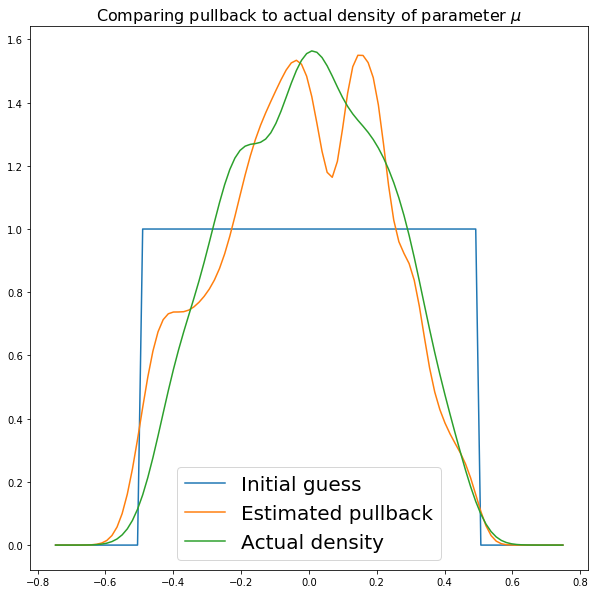

In [70]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

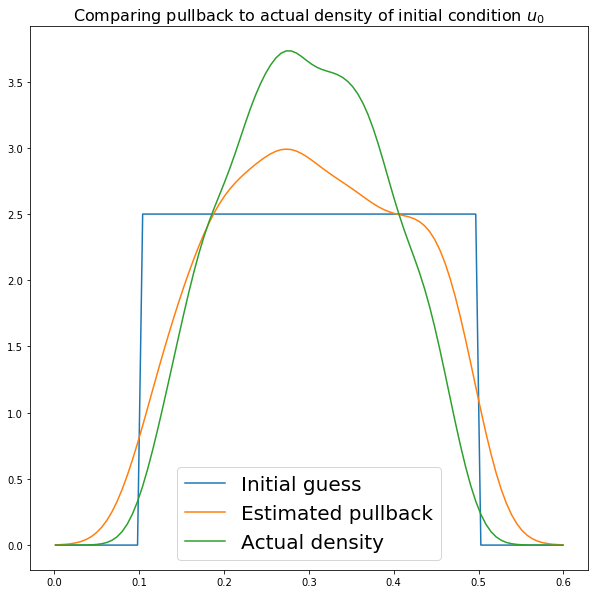

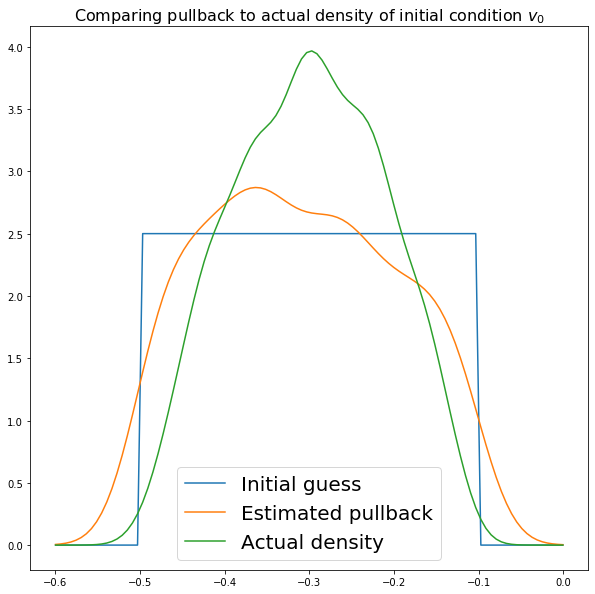

In [71]:
# Plot predicted marginal densities for initial conditions.

for i in range(ics.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(ics[:, i]), min(ics_obs[:, i]))
    x_max = max(max(ics[:, i]), max(ics_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, ic_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += ic_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_ic_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of initial condition ' + ic_labels[i], fontsize=16)
    plt.legend(fontsize=20)